In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("train.csv")
test_raw_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [3]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [4]:
df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
df = df.drop(columns=['id', 'CustomerId', 'Surname'])

In [6]:
input_cols = df.columns.drop('Exited').tolist()
target_col = 'Exited'
X = df[input_cols]
y = df[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
train_inputs = X_train.copy()
train_targets = y_train.copy()
val_inputs = X_val.copy()
val_targets = y_val.copy()

In [8]:
numeric_cols = train_inputs.select_dtypes(include='number').columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

In [9]:
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,658.84,37.69,5.03,43008.17,1.59,0.79,0.49,117992.40
std,72.33,8.14,2.78,59906.63,0.53,0.41,0.50,45589.48
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83343.73
50%,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123613.91
75%,708.00,42.00,7.00,109949.05,2.00,1.00,1.00,156912.81
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


**All numerical features look reasonable, without obvious outliers or technical errors. However, scaling before logistic regression is still advisable to avoid the influence of different scales.**

In [10]:
# number of unique values and the actual categories for each categorical column

for col in categorical_cols:
    print(f"{col}: {train_inputs[col].nunique()} унікальних значень")
    print(train_inputs[col].unique())
    print()

Geography: 3 унікальних значень
['France' 'Germany' 'Spain']

Gender: 2 унікальних значень
['Male' 'Female']



In [11]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

In [12]:
temp_preprocessor = preprocessor.fit(train_inputs)
train_inputs_transformed = temp_preprocessor.transform(train_inputs)
val_inputs_transformed = temp_preprocessor.transform(val_inputs)

encoded_cat_columns = temp_preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + list(encoded_cat_columns)

train_inputs_df = pd.DataFrame(train_inputs_transformed, columns=all_feature_names)
val_inputs_df = pd.DataFrame(val_inputs_transformed, columns=all_feature_names)

print("\nПерші 5 рядків обробленого train_inputs:")
display(train_inputs_df.head())

print("\nПерші 5 рядків обробленого val_inputs:")
display(val_inputs_df.head())


Перші 5 рядків обробленого train_inputs:


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,1.0,0.0,0.0,0.0,1.0
1,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,1.0,0.0,0.0,1.0,0.0
2,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,0.0,1.0,0.0,0.0,1.0
3,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,0.0,0.0,1.0,0.0,1.0
4,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,1.0,0.0,0.0,0.0,1.0



Перші 5 рядків обробленого val_inputs:


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.762592,1.021379,-1.447264,1.214543,4.524299,0.515062,1.016977,-0.988144,0.0,1.0,0.0,0.0,1.0
1,-0.910252,0.406985,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.750392,1.0,0.0,0.0,0.0,1.0
2,0.997620,0.038348,-1.087792,-0.717950,0.769304,-1.941514,1.016977,-0.022404,1.0,0.0,0.0,1.0,0.0
3,0.195761,0.652742,-0.368848,1.881867,-1.108193,-1.941514,1.016977,-0.139723,1.0,0.0,0.0,1.0,0.0
4,0.264887,-0.944682,-0.368848,-0.717950,0.769304,0.515062,-0.983306,0.563519,0.0,0.0,1.0,1.0,0.0


In [13]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (12000, 10)
train_targets: (12000,)
val_inputs: (3000, 10)
val_targets: (3000,)


In [14]:
os.chdir("bank-customer-churn-prediction-dlu-course-c-3")

In [15]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

In [16]:
os.listdir("bank-customer-churn-prediction-dlu-course-c-3")

['submission_log_reg.csv',
 'train_targets.parquet',
 'test.csv',
 'log_reg.joblib',
 'train_inputs.parquet',
 'val_inputs.parquet',
 'train.csv',
 'val_targets.parquet',
 'sample_submission.csv']

In [17]:
train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')

train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]

In [18]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (12000, 10)
train_targets: (12000,)
val_inputs: (3000, 10)
val_targets: (3000,)


In [19]:
model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [20]:
def evaluate_pipeline(pipeline, X, y, name):
    y_proba = pipeline.predict_proba(X)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    print(f"\n--- {name.upper()} ---")
    print("ROC AUC:", round(roc_auc_score(y, y_proba), 4))
    print("F1 Score:", round(f1_score(y, y_pred), 4))

    ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    RocCurveDisplay.from_predictions(y, y_proba)
    plt.title(f"ROC Curve - {name}")
    plt.show()


--- TRAIN ---
ROC AUC: 0.8825
F1 Score: 0.6402


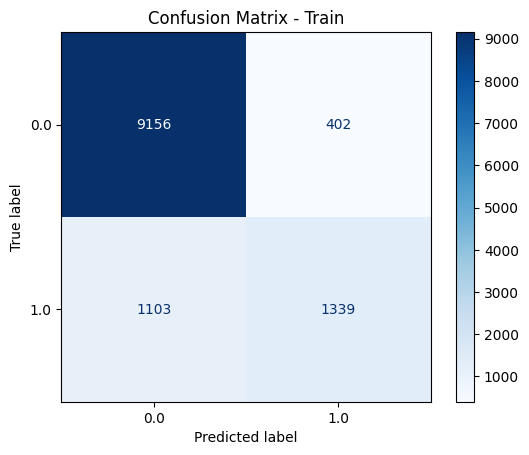

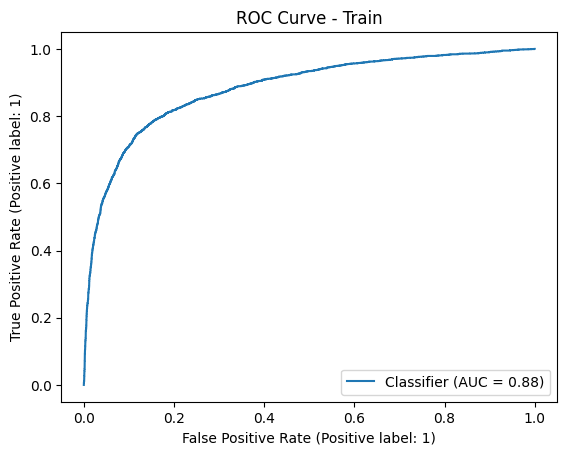


--- VALIDATION ---
ROC AUC: 0.8797
F1 Score: 0.639


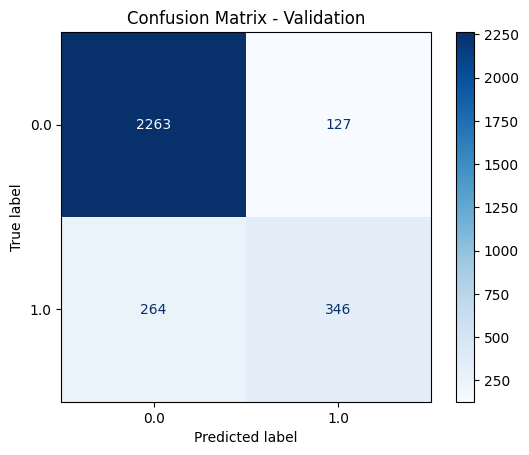

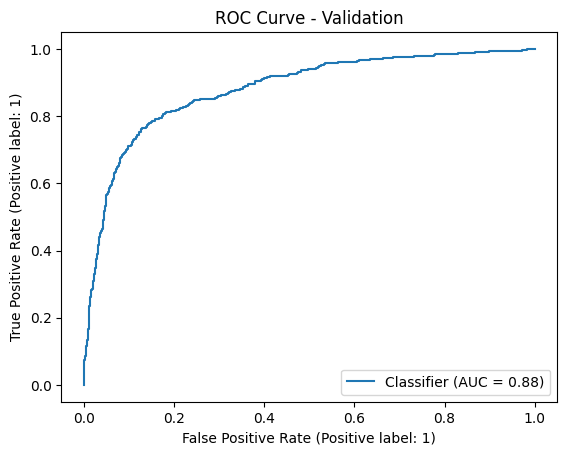

In [21]:
evaluate_pipeline(model_pipeline, train_inputs, train_targets, "Train")
evaluate_pipeline(model_pipeline, val_inputs, val_targets, "Validation")

**The model provides good performance with a fairly simple implementation.**

In [22]:
# comparing a simple baseline (majority class prediction) with Logistic Regression

majority_class = train_targets.mode()[0]
def predict_majority(X):
    return np.full(len(X), majority_class)

def accuracy_majority(X, y):
    preds = predict_majority(X)
    return np.mean(preds == y)

print("\nBaseline accuracy:")
print("Train:", round(accuracy_majority(train_inputs, train_targets), 4))
print("Validation:", round(accuracy_majority(val_inputs, val_targets), 4))

train_preds = model_pipeline.predict(train_inputs)
val_preds = model_pipeline.predict(val_inputs)

print("\nLogistic Regression accuracy:")
print("Train:", round(accuracy_score(train_targets, train_preds), 4))
print("Validation:", round(accuracy_score(val_targets, val_preds), 4))


Baseline accuracy:
Train: 0.7965
Validation: 0.7967

Logistic Regression accuracy:
Train: 0.8746
Validation: 0.8697


**The logistic regression model outperforms the baseline model in terms of accuracy. This indicates that it has learned to capture patterns in the data rather than simply guessing the most frequent class.**

In [23]:
joblib.dump(model_pipeline, "log_reg.joblib")
model_2 = joblib.load("log_reg.joblib")

In [24]:
# preprocessing raw input data and returning the predicted probability of class 1 for each row

def predict_raw_df(model, raw_df, numeric_cols, categorical_cols):
    df_proc = raw_df.copy()
    df_proc = df_proc.drop(columns=['id', 'CustomerId', 'Surname'], errors='ignore')
    probs = model.predict_proba(df_proc)[:, 1]
    return probs

In [27]:
test_raw_df['Exited'] = predict_raw_df(model_2, test_raw_df, numeric_cols, categorical_cols)

In [28]:
# creating submission dataframe in Kaggle format

submission_df = sample_submission.copy()
submission_df['Exited'] = test_raw_df['Exited']
submission_df.head()

,id,Exited
0,15000,0.069393
1,15001,0.033314
2,15002,0.153586
3,15003,0.199192
4,15004,0.054281


In [29]:
submission_df.to_csv("submission_log_reg.csv", index=False)